In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import re
import string
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import re
import csv
import pickle
from collections import defaultdict
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim
import pandas as pd
from gensim.test.utils import common_texts
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import hdpmodel, ldamodel
from pprint import pprint

In [2]:
# load the tips data
tips = pd.read_csv("/Users/avarezvani/Downloads/yelp-dataset/tips_final.csv")

In [3]:
tips.head()

,business_id,name,postal_code,stars,review_count,categories,user_id,text,date,compliment_count,text_length,tips_id,text_new
0,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,28210,4.0,170,"Sushi Bars, Restaurants, Japanese",JysF40STBTmx7h-sU1FHgg,Tonkatsu Ramen!!!,2013-02-20 23:22:46,0,17,0,tonkatsu ramen
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,28210,4.0,170,"Sushi Bars, Restaurants, Japanese",FyikYazQbNoOumDooOQyyA,"Ramen, Gyoza, miso soup and green tea ice crea...",2018-01-19 05:31:59,0,59,1,ramen gyoza miso soup green tea ice cream great
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,28210,4.0,170,"Sushi Bars, Restaurants, Japanese",FyikYazQbNoOumDooOQyyA,Best ramen I've had in the Charlotte area,2017-04-08 05:34:25,0,41,2,best ramen ive charlotte area
3,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,28210,4.0,170,"Sushi Bars, Restaurants, Japanese",7M-rWYRGPfCDnb7tjl7QGQ,Get whatever lunch special A or B is. Trust me...,2011-11-19 18:19:24,0,66,3,get whatever lunch special trust
4,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,28210,4.0,170,"Sushi Bars, Restaurants, Japanese",MZFUSBTj7RDpf19v5qP9HA,Best Chirazshi in town!,2016-02-26 22:43:31,0,23,4,best chirazshi town


In [53]:
# identify the number of restaurants
tips["business_id"].nunique()

31828

In [54]:
combined_tips = tips[["name", "text_new"]]

In [55]:
combined_tips.head()

,name,text_new
0,Musashi Japanese Restaurant,tonkatsu ramen
1,Musashi Japanese Restaurant,ramen gyoza miso soup green tea ice cream great
2,Musashi Japanese Restaurant,best ramen ive charlotte area
3,Musashi Japanese Restaurant,get whatever lunch special trust
4,Musashi Japanese Restaurant,best chirazshi town


In [56]:
# combining the tips together per restaurant

combined_tips = combined_tips.groupby("name")["text_new"].apply(lambda x: ', '.join(x.astype(str)))

combined_tips.head()

name
#1 Fried Rice           ill make short food bad, avoid business tolles...
#1 Hawaiian Barbecue    grand opening special, hawaiianinspired food r...
#1 Pho                    stopped pho look like theyre closed permanently
#1 Sushi                fast sushi, cant beat 199 chicken bowl place b...
#1Brothers Pizza        uwzz, place worst cold pizza soggy wing overco...
Name: text_new, dtype: object

In [57]:
combined_tips = combined_tips.to_frame()

In [58]:
list(combined_tips.columns.values)

['text_new']

In [59]:
combined_tips.head()

,text_new
name,
#1 Fried Rice,"ill make short food bad, avoid business tolles..."
#1 Hawaiian Barbecue,"grand opening special, hawaiianinspired food r..."
#1 Pho,stopped pho look like theyre closed permanently
#1 Sushi,"fast sushi, cant beat 199 chicken bowl place b..."
#1Brothers Pizza,"uwzz, place worst cold pizza soggy wing overco..."


### Tokenizing

In [60]:
def tokenize_sentences(sentences):
    for x in sentences:
        yield(gensim.utils.simple_preprocess(str(x)))

tokens = list(tokenize_sentences(combined_tips.text_new.values.tolist()))

print(tokens[0:9])

[['ill', 'make', 'short', 'food', 'bad', 'avoid', 'business', 'tolleson', 'main', 'street', 'speed', 'trap', 'mile', 'speed', 'limit', 'aggresive', 'police', 'issue', 'ticket', 'avoid', 'tolleson', 'business', 'today', 'beef', 'broccoli', 'low', 'mein', 'bada', 'bing', 'calling', 'ahead', 'best', 'bet', 'youre', 'big', 'portion', 'cheap', 'price', 'cant', 'wrong', 'taste', 'great', 'big', 'portion', 'cheap', 'price', 'cant', 'wrong', 'place', 'closed', 'longer', 'business', 'price', 'good', 'give', 'lot', 'price', 'food', 'good', 'tasty', 'food', 'cheap', 'price', 'huge', 'portion', 'food', 'served'], ['grand', 'opening', 'special', 'food', 'real', 'deal', 'duplicate', 'business', 'listing', 'hawaiian', 'barbecue', 'new', 'joint', 'like', 'low', 'carb', 'plate', 'option', 'got', 'chicken', 'katsu', 'okay', 'ive', 'much', 'better', 'elsewhere', 'north', 'location', 'hawaiian', 'food', 'deliver', 'poke', 'bomb', 'seaweed', 'salad', 'plus', 'cheap', 'fast', 'mac', 'salad', 'isnt', 'best',

### Developing model for Bigrams & Trigrams with gensim

In [61]:
bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tokens], threshold=100)

In [62]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [63]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [71]:
data_words_bigrams = make_bigrams(tokens)

data_words_trigrams = make_trigrams(tokens)

print(data_words_bigrams[0:50])

# note the first bigram seen with "tokatsu_ramen"

[['ill', 'make', 'short', 'food', 'bad', 'avoid', 'business', 'tolleson', 'main', 'street', 'speed', 'trap', 'mile', 'speed', 'limit', 'aggresive', 'police', 'issue', 'ticket', 'avoid', 'tolleson', 'business', 'today', 'beef', 'broccoli', 'low', 'mein', 'bada_bing', 'calling_ahead', 'best', 'bet', 'youre', 'big', 'portion', 'cheap', 'price', 'cant', 'wrong', 'taste', 'great', 'big', 'portion', 'cheap', 'price', 'cant', 'wrong', 'place', 'closed', 'longer', 'business', 'price', 'good', 'give', 'lot', 'price', 'food', 'good', 'tasty', 'food', 'cheap', 'price', 'huge', 'portion', 'food', 'served'], ['grand_opening', 'special', 'food', 'real', 'deal', 'duplicate', 'business', 'listing', 'hawaiian', 'barbecue', 'new', 'joint', 'like', 'low_carb', 'plate', 'option', 'got', 'chicken', 'katsu', 'okay', 'ive', 'much', 'better', 'elsewhere', 'north', 'location', 'hawaiian', 'food', 'deliver', 'poke', 'bomb', 'seaweed', 'salad', 'plus', 'cheap', 'fast', 'mac', 'salad', 'isnt', 'best', 'town', 'ta

In [ ]:
### Baseline with word cloud

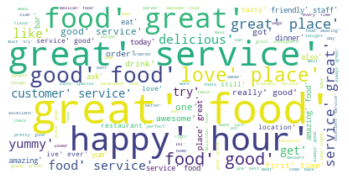

In [65]:
# Baseline with a word cloud
words = str(data_words_bigrams)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### interesting insights from the wordcloud include:
- mentions of food and service (both of which would help to be seen in the reviews
- mentions of a "happy hour" (which would be helpful to see up top and closer to hours of operation)
- mentions of "like" and "try" (which would be helpful for the popular dishes section of Yelp)
- interesting to see that there is a lot of positivity in the reviews: are tips generally more positive than negative?
- also interesting that there is "good food" and also "food good." I think there is some room to combine these, as we look into the topics.

### LDA


In [70]:
# creating a dictionary
id2word = corpora.Dictionary(data_words_bigrams)
dictionary = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

In [72]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [73]:
print(corpus[0:20])
# can see many unique words here

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 3), (10, 1), (11, 2), (12, 3), (13, 1), (14, 4), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 3), (32, 5), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 2), (44, 1)], [(5, 1), (9, 1), (12, 1), (14, 2), (38, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1)], [(13, 1), (64, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1)], [(5, 1), (12, 1), (14, 2), (16, 1), (29, 1), (32, 1), (49, 1), (55, 1), (63, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1

In [74]:
# LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10,chunksize=1000, passes=1)

In [75]:
# Print the Keyword in the 10 topics
pprint(lda_model.show_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"taco" + 0.034*"food" + 0.022*"good" + 0.021*"great" + 0.020*"best" + '
  '0.017*"burrito" + 0.017*"mexican" + 0.014*"salsa" + 0.014*"place" + '
  '0.011*"margarita"'),
 (1,
  '0.029*"food" + 0.024*"good" + 0.023*"sushi" + 0.019*"great" + 0.018*"place" '
  '+ 0.016*"best" + 0.014*"service" + 0.013*"roll" + 0.011*"love" + '
  '0.010*"lunch"'),
 (2,
  '0.173*"wing" + 0.045*"tea" + 0.040*"boba" + 0.021*"gelato" + 0.015*"milk" + '
  '0.009*"flavor" + 0.008*"slush" + 0.007*"honey" + 0.007*"hot" + '
  '0.006*"shaved_ice"'),
 (3,
  '0.067*"food" + 0.061*"great" + 0.037*"service" + 0.035*"good" + '
  '0.025*"place" + 0.014*"best" + 0.013*"love" + 0.013*"amazing" + '
  '0.011*"awesome" + 0.009*"back"'),
 (4,
  '0.108*"pizza" + 0.020*"great" + 0.020*"best" + 0.019*"good" + '
  '0.013*"italian" + 0.012*"place" + 0.011*"love" + 0.009*"sandwich" + '
  '0.009*"slice" + 0.009*"get"'),
 (5,
  '0.018*"hour" + 0.017*"happy" + 0.015*"great" + 0.013*"drink" + '
  '0.013*"place" + 0.011*"bar"

In [76]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("coherence score:", coherence_lda)


Coherence Score:  0.3529372170711519


In [81]:
print("model perplexity score:", lda_model.log_perplexity(corpus))

model perplexity score: -7.832164759912205


In [89]:
def coherence_scores(dictionary, corpus, texts, limit, start=1, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10,chunksize=1000, passes=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [93]:
model_list, coherence_score = coherence_scores(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=1, limit=20, step=1)



In [101]:
for t, c_score in zip(x, coherence_score):
    print("topic #", t, "coherence score", c_score)

topic_n 1  has Coherence Value of 0.3829
topic_n 3  has Coherence Value of 0.3384
topic_n 5  has Coherence Value of 0.4023
topic_n 7  has Coherence Value of 0.3362
topic_n 9  has Coherence Value of 0.3035
topic_n 11  has Coherence Value of 0.3432
topic_n 13  has Coherence Value of 0.3311
topic_n 15  has Coherence Value of 0.3292
topic_n 17  has Coherence Value of 0.3584
topic_n 19  has Coherence Value of 0.3221


In [111]:
# LDA Model with n = 5 for perplexity score:

lda_model = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5,chunksize=1000, passes=1)

In [103]:
print("model perplexity score:", lda_model.log_perplexity(corpus))

model perplexity score: -7.468639592202943


In [107]:
lda_model = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5,chunksize=5000, passes=5)

In [112]:
pprint(lda_model.show_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"breakfast" + 0.014*"great" + 0.013*"place" + 0.012*"good" + '
  '0.011*"coffee" + 0.011*"get" + 0.010*"love" + 0.009*"sandwich" + '
  '0.009*"service" + 0.009*"burger"'),
 (1,
  '0.194*"pizza" + 0.026*"wing" + 0.017*"best" + 0.015*"slice" + 0.012*"great" '
  '+ 0.011*"italian" + 0.009*"donut" + 0.009*"crust" + 0.008*"pie" + '
  '0.008*"cheese"'),
 (2,
  '0.021*"beer" + 0.018*"great" + 0.013*"good" + 0.013*"place" + 0.011*"food" '
  '+ 0.010*"bar" + 0.010*"wing" + 0.009*"drink" + 0.008*"time" + '
  '0.008*"night"'),
 (3,
  '0.032*"great" + 0.020*"food" + 0.018*"service" + 0.016*"sushi" + '
  '0.016*"good" + 0.015*"place" + 0.014*"happy" + 0.014*"hour" + '
  '0.011*"amazing" + 0.011*"best"'),
 (4,
  '0.045*"food" + 0.035*"great" + 0.029*"good" + 0.021*"service" + '
  '0.020*"place" + 0.016*"best" + 0.013*"love" + 0.010*"chicken" + '
  '0.009*"delicious" + 0.008*"amazing"')]


In [115]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("coherence score:", coherence_lda)

coherence score: 0.31585625231101344


In [116]:
print("model perplexity score:", lda_model.log_perplexity(corpus))

model perplexity score: -7.463464903310432
